## Predicting the Next Winning "Mega Millions" Numbers using a Deep Neural Network

Author: Morgan McAnally, Ph.D.

"Mega Millions" was up to 1.58 billion on August 8th, 2023, when a Florida man won and, thus, has created a lot of buzz. I had bought a ticket the weekend before. As I was off to a dentist appointment I had an idea, I want to forecast the winning numbers of the "Mega Millions" lottery using Deep Learning. I have recently completed some self-taught courses and wanted do a project to strengthen my knowledge. This work uses as a reference "Forecasting the Next Winning Numbers in the Texas Lottery 'Mega Millions' Drawing using A Deep Neural Network with TensorFlow's Keras API" by Roi Polanitzer. The link is [here](https://medium.com/@polanitzer/forecasting-the-next-winning-numbers-in-the-texas-lottery-mega-millions-drawing-using-a-deep-4c37ee6d30f0).

In [2]:
# Initiate some of the packages we use later
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

The first data I used was a Kaggle dataset. I used an API, see [reference](https://saturncloud.io/blog/how-to-import-kaggle-datasets-into-jupyter-notebook/) on how to do this, and download the dataset found on Kaggle [here](https://www.kaggle.com/datasets/chrico03/us-mega-millions-historical-numbers). I cleaned the data in the notebook 'cleaning_kaggle_data.ipynb'. This data covers the years 2010 to 2022.

In [125]:
df = pd.read_csv("data//mega_millions_2010_to_2022.csv")

In [126]:
df.tail()

,date,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
1298,2/16/2010,11.0,12.0,21.0,29.0,45.0,5.0,3.0
1299,2/12/2010,14.0,16.0,17.0,33.0,47.0,23.0,4.0
1300,2/9/2010,2.0,17.0,20.0,26.0,48.0,12.0,4.0
1301,2/5/2010,10.0,20.0,45.0,51.0,53.0,41.0,4.0
1302,2/2/2010,6.0,7.0,26.0,27.0,49.0,9.0,4.0


In [8]:
df.head()

,date,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,7/26/2022,7.0,29.0,60.0,63.0,66.0,15.0,3.0
1,7/22/2022,14.0,40.0,60.0,64.0,66.0,16.0,3.0
2,7/19/2022,2.0,31.0,32.0,37.0,70.0,25.0,3.0
3,7/15/2022,8.0,20.0,26.0,53.0,64.0,15.0,5.0
4,7/12/2022,4.0,7.0,10.0,45.0,64.0,12.0,2.0


Now, let's make a dataset we can train. The problem is "Can we predict the Mega Millions winning numbers by a sequence of previous numbers?" How many previous drawings seem reasonable? Let's say a week. This will be our window.

In [127]:
window_length = 7
window_length

7

The date should have no affect on the numbers drawn. Let's remove it so it doesn't provide any added noise. We will also take a copy before we remove the date to use later.

In [128]:
df1 = df.copy()
df.drop(['date'], axis=1, inplace=True)

number_of_features = df.shape[1]

In [ ]:
# The number of variable used to predict include 5 balls, one mega ball, and one mega multiplier
number_of_features

In [129]:
train = df.copy()
train.head((window_length+1))

,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,7.0,29.0,60.0,63.0,66.0,15.0,3.0
1,14.0,40.0,60.0,64.0,66.0,16.0,3.0
2,2.0,31.0,32.0,37.0,70.0,25.0,3.0
3,8.0,20.0,26.0,53.0,64.0,15.0,5.0
4,4.0,7.0,10.0,45.0,64.0,12.0,2.0
5,20.0,36.0,61.0,62.0,69.0,20.0,3.0
6,27.0,31.0,50.0,51.0,61.0,21.0,4.0
7,1.0,27.0,29.0,38.0,62.0,12.0,3.0


In [130]:
# Head of dataset with date
df1.head((window_length+1))

,date,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,7/26/2022,7.0,29.0,60.0,63.0,66.0,15.0,3.0
1,7/22/2022,14.0,40.0,60.0,64.0,66.0,16.0,3.0
2,7/19/2022,2.0,31.0,32.0,37.0,70.0,25.0,3.0
3,7/15/2022,8.0,20.0,26.0,53.0,64.0,15.0,5.0
4,7/12/2022,4.0,7.0,10.0,45.0,64.0,12.0,2.0
5,7/8/2022,20.0,36.0,61.0,62.0,69.0,20.0,3.0
6,7/5/2022,27.0,31.0,50.0,51.0,61.0,21.0,4.0
7,7/1/2022,1.0,27.0,29.0,38.0,62.0,12.0,3.0


To set our training set up properly, let's use the above code snippet as an example. We want to predict the drawing on '7/26/2022' by the previous 7 drawings. Therefore, our input, or samples, is rows 1-7 and corresponding output, or label, should be row 0. Then, we repeat this pattern. To predict '7/22/2022', our samples would be rows 2-8 and our label is row 1. Let's make the training set.

In [131]:
# Define the number of rows in the data set
train_rows = train.values.shape[0]

# Initialize the training sample and label arrays
train_samples = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
train_labels = np.empty([ train_rows - window_length, number_of_features], dtype=float)

In [132]:
print(train_rows)
print(train_samples.shape)
print(train_labels.shape)

1303
(1296, 7, 7)
(1296, 7)


In [133]:
for i in range(0, train_rows-window_length):
    train_samples[i] = train.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    train_labels[i] = train.iloc[i : i+1, 0 : number_of_features]

Look at the head of the dataset with the date and notice the rows 1-7. These are in train sample 0.

In [134]:
train_samples[0]

array([[14., 40., 60., 64., 66., 16.,  3.],
       [ 2., 31., 32., 37., 70., 25.,  3.],
       [ 8., 20., 26., 53., 64., 15.,  5.],
       [ 4.,  7., 10., 45., 64., 12.,  2.],
       [20., 36., 61., 62., 69., 20.,  3.],
       [27., 31., 50., 51., 61., 21.,  4.],
       [ 1., 27., 29., 38., 62., 12.,  3.]])

The corresponding label for sample 0 is row 0 in the dataset with the date.

In [18]:
train_labels[0]

array([ 7., 29., 60., 63., 66., 15.,  3.])

It is good practice to standardized the data for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data. The standardization below will make the data set Gaussian with a mean of 0 and a standard deviation of 1.

In [135]:
scaler = StandardScaler()
transformed_dataset = scaler.fit_transform(train.values)
scaled_train_samples = pd.DataFrame(data=transformed_dataset, index=train.index)

In [136]:
scaled_train_samples.head(window_length+1)

,0,1,2,3,4,5,6
0,-0.439640,0.586888,2.073230,1.429582,0.840481,0.011409,-0.368114
1,0.358679,1.526762,2.073230,1.507232,0.840481,0.103172,-0.368114
2,-1.009867,0.757774,-0.086239,-0.589318,1.183894,0.929040,-0.368114
3,-0.325594,-0.182099,-0.548982,0.653082,0.668774,0.011409,1.651478
4,-0.781776,-1.292859,-1.782964,0.031882,0.668774,-0.263881,-1.377910
5,1.042952,1.184990,2.150354,1.351932,1.098041,0.470225,-0.368114
6,1.841271,0.757774,1.301991,0.497782,0.411214,0.561988,0.641682
7,-1.123913,0.416002,-0.317611,-0.511668,0.497067,-0.263881,-0.368114


In [137]:
x_train = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
y_train = np.empty([ train_rows - window_length, number_of_features], dtype=float)

for i in range(0, train_rows-window_length):
    x_train[i] = scaled_train_samples.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    y_train[i] = scaled_train_samples.iloc[i : i+1, 0 : number_of_features]

In [22]:
x_train[0]

array([[ 0.35867887,  1.52676175,  2.07322964,  1.50723244,  0.84048066,
         0.10317192, -0.36811443],
       [-1.00986745,  0.75777429, -0.08623906, -0.58931763,  1.18389437,
         0.92904025, -0.36811443],
       [-0.32559429, -0.18209927, -0.54898235,  0.65308241,  0.66877381,
         0.01140877,  1.65147757],
       [-0.7817764 , -1.29285894, -1.78296447,  0.03188239,  0.66877381,
        -0.26388067, -1.37791043],
       [ 1.04295204,  1.18498955,  2.15035352,  1.35193243,  1.09804094,
         0.47022451, -0.36811443],
       [ 1.84127073,  0.75777429,  1.30199082,  0.4977824 ,  0.41121353,
         0.56198766,  0.64168157],
       [-1.12391298,  0.41600209, -0.31761071, -0.51166763,  0.49706696,
        -0.26388067, -0.36811443]])

In [23]:
y_train[0]

array([-0.43963982,  0.58688819,  2.07322964,  1.42958243,  0.84048066,
        0.01140877, -0.36811443])

For best practice, let's make a train set, a validation set, and a test set.

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mse
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

Let's use an LSTM model. We create a class that will record the time each epoch takes as well as the current time. If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [26]:
import pytz
from time import time
from datetime import datetime

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.cur_times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        timezone = pytz.timezone('US/Eastern')
        now = datetime.now(tz = timezone)
        self.cur_time = now.strftime("%I:%M:%S %p")
        self.times.append(time() - self.epoch_time_start)
        self.cur_times.append(self.cur_time)
        print(self.cur_time)

In [27]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [29]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [30]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [31]:
#model for 2010 to 2022

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=2000
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2400,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Streaming output truncated to the last 5000 lines.
Epoch 477/2400
07:16:33 PM
10/10 - 0s - loss: 0.0122 - accuracy: 0.9284 - val_loss: 1.3738 - val_accuracy: 0.2343 - 255ms/epoch - 26ms/step
Epoch 478/2400
07:16:34 PM
10/10 - 0s - loss: 0.0123 - accuracy: 0.9304 - val_loss: 1.3527 - val_accuracy: 0.2343 - 274ms/epoch - 27ms/step
Epoch 479/2400
07:16:34 PM
10/10 - 0s - loss: 0.0122 - accuracy: 0.9263 - val_loss: 1.3542 - val_accuracy: 0.2286 - 252ms/epoch - 25ms/step
Epoch 480/2400
07:16:34 PM
10/10 - 0s - loss: 0.0120 - accuracy: 0.9294 - val_loss: 1.3599 - val_accuracy: 0.2286 - 247ms/epoch - 25ms/step
Epoch 481/2400
07:16:34 PM
10/10 - 0s - loss: 0.0126 - accuracy: 0.9233 - val_loss: 1.3533 - val_accuracy: 0.2457 - 247ms/epoch - 25ms/step
Epoch 482/2400
07:16:35 PM
10/10 - 0s - loss: 0.0118 - accuracy: 0.9344 - val_loss: 1.3569 - val_accuracy: 0.2343 - 255ms/epoch - 26ms/step
Epoch 483/2400
07:16:35 PM
10/10 - 0s - loss: 0.0123 - accuracy: 0.9062 - val_loss: 1.3362 - val_accuracy: 0.

In [32]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 98%.
The validation accuracy is 25%.
The test accuracy is 29%.


In [33]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 7.359171772003174 minutes.


In an effort to raise the validation accuracy, let's add regularization to each Bidirectional LSTM layer.

In [139]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [140]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [141]:
#model for 2010 to 2022

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=1900
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2400,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Streaming output truncated to the last 5000 lines.
Epoch 411/2400
08:55:24 PM
10/10 - 0s - loss: 0.0760 - accuracy: 0.7972 - val_loss: 1.2598 - val_accuracy: 0.2457 - 254ms/epoch - 25ms/step
Epoch 412/2400
08:55:25 PM
10/10 - 0s - loss: 0.0781 - accuracy: 0.8163 - val_loss: 1.2603 - val_accuracy: 0.2800 - 239ms/epoch - 24ms/step
Epoch 413/2400
08:55:25 PM
10/10 - 0s - loss: 0.0742 - accuracy: 0.8093 - val_loss: 1.2793 - val_accuracy: 0.2857 - 182ms/epoch - 18ms/step
Epoch 414/2400
08:55:25 PM
10/10 - 0s - loss: 0.0746 - accuracy: 0.8285 - val_loss: 1.2786 - val_accuracy: 0.2743 - 177ms/epoch - 18ms/step
Epoch 415/2400
08:55:25 PM
10/10 - 0s - loss: 0.0720 - accuracy: 0.8153 - val_loss: 1.2577 - val_accuracy: 0.2800 - 196ms/epoch - 20ms/step
Epoch 416/2400
08:55:25 PM
10/10 - 0s - loss: 0.0796 - accuracy: 0.7941 - val_loss: 1.2977 - val_accuracy: 0.2743 - 195ms/epoch - 19ms/step
Epoch 417/2400
08:55:26 PM
10/10 - 0s - loss: 0.0724 - accuracy: 0.8214 - val_loss: 1.2651 - val_accuracy: 0.

In [142]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 97%.
The validation accuracy is 32%.
The test accuracy is 31%.


In [143]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 7.407 minutes.


We see that the validation accuracy was raised about 7%. Now, let's see some examples from the predictions and actual values. 

In [41]:
from random import randint, seed

In [144]:
print('-' * 40)
print('Prediction vs. GoundTruth without rounding up or down')

n = randint(0,1000)
seed(n)
for i in range(0,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0])
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth without rounding up or down
1/1 [==============================] - 3s 3s/step
Drawing  Date 11/30/2010
Prediction:	 [ 5  8 11 13 51 13  3]
GoundTruth:	 [11 16 19 47 53  2  4]
----------------------------------------
1/1 [==============================] - 0s 24ms/step
Drawing  Date 11/23/2018
Prediction:	 [ 7 10 30 33 59 23  4]
GoundTruth:	 [ 7 10 30 33 59 23  4]
----------------------------------------
1/1 [==============================] - 0s 28ms/step
Drawing  Date 11/7/2017
Prediction:	 [ 9 29 44 54 63  8  3]
GoundTruth:	 [ 1 54 60 68 69 11  4]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 3/23/2018
Prediction:	 [ 6 24 47 59 59  7  3]
GoundTruth:	 [ 4  8 23 53 59 17  3]
----------------------------------------
1/1 [==============================] - 0s 31ms/step
Drawing  Date 3/26/2013
Prediction:	 [20 32 45 47 50 46  4]
GoundTruth:	 [20 33 46 49 51 46  4]
-

We find some of the answers are off by only a one integer. Let's try rounding up.

In [145]:
print('-' * 40)
print('Prediction vs. GoundTruth with rounding up')

seed(n)
for i in range(1,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0]+1)
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth with rounding up
1/1 [==============================] - 0s 26ms/step
Drawing  Date 11/30/2010
Prediction:	 [ 6  9 12 14 52 14  4]
GoundTruth:	 [11 16 19 47 53  2  4]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 11/23/2018
Prediction:	 [ 8 11 31 34 60 24  5]
GoundTruth:	 [ 7 10 30 33 59 23  4]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 11/7/2017
Prediction:	 [10 30 45 55 64  9  4]
GoundTruth:	 [ 1 54 60 68 69 11  4]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 3/23/2018
Prediction:	 [ 7 25 48 60 60  8  4]
GoundTruth:	 [ 4  8 23 53 59 17  3]
----------------------------------------
1/1 [==============================] - 0s 24ms/step
Drawing  Date 3/26/2013
Prediction:	 [21 33 46 48 51 47  5]
GoundTruth:	 [20 33 46 49 51 46  4]
----------

The original data used was from 2010 to 2022. Let's upload data from 2010 to present and see how well it predicts Mega Millions Lotto numbers in August of 2023.

In [146]:
import copy
df_next = pd.read_csv('data/mega_millions_2010_to_present.csv')

In [147]:
print('-' * 40)
print('Prediction vs. GoundTruth with rounding up')
for i in range(1,5):
    test = df_next.copy()
    test = test.head((window_length+5-i))
    test = test.tail((window_length+1))
    test_Date = df_next.iloc[test.head().index[0]]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0]+1)
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth with rounding up
1/1 [==============================] - 0s 25ms/step
Drawing  Date 8/18/2023
Prediction:	 [11 16 37 46 57 19  4]
GoundTruth:	 [10 20 29 44 66 11  3]
----------------------------------------
1/1 [==============================] - 0s 25ms/step
Drawing  Date 8/22/2023
Prediction:	 [14 21 40 52 64 27  4]
GoundTruth:	 [ 1 12 26 36 50  7  2]
----------------------------------------
1/1 [==============================] - 0s 24ms/step
Drawing  Date 8/25/2023
Prediction:	 [ 7 12 21 39 56 22  3]
GoundTruth:	 [12 23 26 31 38  2  2]
----------------------------------------
1/1 [==============================] - 0s 30ms/step
Drawing  Date 8/29/2023
Prediction:	 [10 18 31 45 53 26  3]
GoundTruth:	 [ 9 39 52 61 63 25  3]
----------------------------------------


In [148]:
last_Date = df_next.iloc[0]['date']
print('-' * 40)
print('Predict the Drawing on '+datetime.strptime(str(last_Date),'%m/%d/%Y').strftime("%b %d %Y")+ ' vs. True Drawing')
next_draw = df_next.copy()
next_draw = next_draw.head((window_length+1))
next_draw1 = next_draw.tail((window_length))
next_draw1 = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw1 = np.array(next_draw1)
x_next = scaler.transform(next_draw1)
y_next_pred = model.predict(np.array([x_next]))
y_test_true = next_draw.drop(['date'], errors='ignore', axis=1)
y_test_true = y_test_true.head(1)
print('Drawing  Date', last_Date)
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('Truth                                 :\t', np.array(y_test_true.astype(int))[0])
print('-' * 40)

----------------------------------------
Predict the Drawing on Aug 29 2023 vs. True Drawing
1/1 [==============================] - 4s 4s/step
Drawing  Date 8/29/2023
Prediction without rounding up or down:	 [13 23 30 41 60 12  1]
Prediction with rounding up           :	 [14 24 31 42 61 13  2]
Prediction with rounding down         :	 [12 22 29 40 59 11  0]
Truth                                 :	 [ 9 39 52 61 63 25  3]
----------------------------------------


We can see this model does not do a good job of generalization to the future. Here is the prediction for the next drawing passed August 29, 2023. 

In [149]:
print('-' * 40)
print('Predict the Next Drawing')
next_draw = df_next.copy()
next_draw = next_draw.head((window_length))
next_draw = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw = np.array(next_draw)
x_next = scaler.transform(next_draw)
y_next_pred = model.predict(np.array([x_next]))
print('Next Drawing')
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('-' * 40)

----------------------------------------
Predict the Next Drawing
1/1 [==============================] - 0s 28ms/step
Next Drawing
Prediction without rounding up or down:	 [18 24 35 42 54  8  2]
Prediction with rounding up           :	 [19 25 36 43 55  9  3]
Prediction with rounding down         :	 [17 23 34 41 53  7  1]
----------------------------------------


Below, we find a model accuracy and model loss curve over time. 

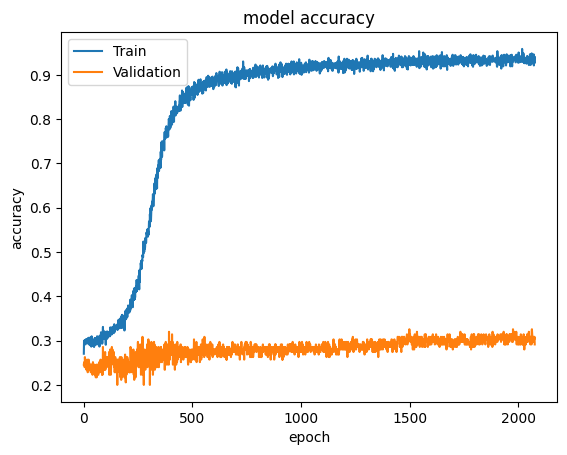

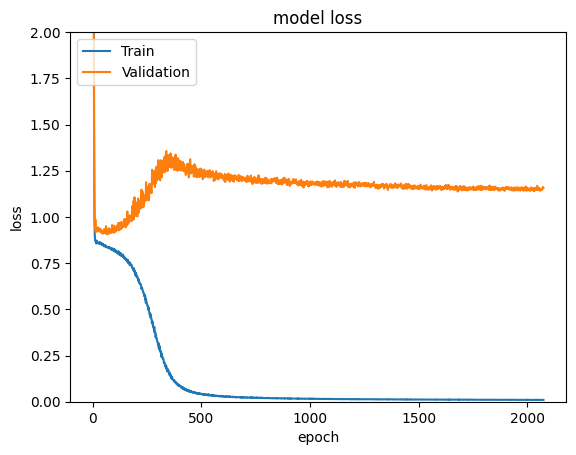

<Figure size 640x480 with 0 Axes>

In [150]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_accuracy_2010_to_2022.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,2)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_loss_2010_to_2022.png')

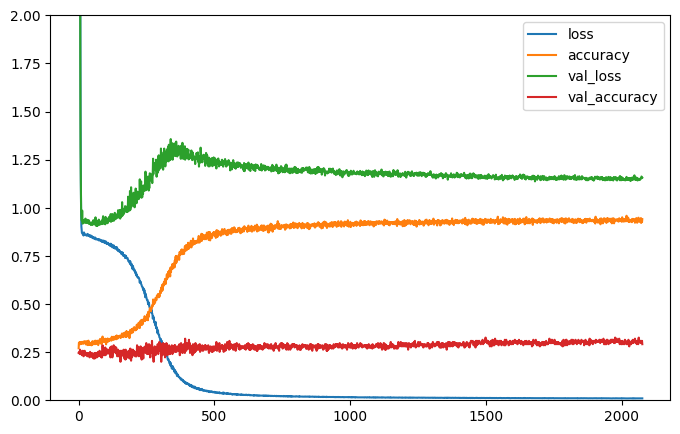

<Figure size 640x480 with 0 Axes>

In [151]:
ax = pd.DataFrame(history.history).plot(figsize=(8,5))
ax.set_ylim(0,2)
plt.show()
#plt.savefig('model_hist_2010_to_2022.png')

In [55]:
#model.save("model_2010_to_2022.tf", overwrite=True, save_format="tf")

In [152]:
#pd.DataFrame.from_dict(history.history).to_csv('history_2010_to_2022.csv',index=False)

Let's try to get a better model. We need more data. The CSV file was generated in the webscraping.ipynb file. The data was found by scraping the Mega Millions website for previous drawings until the present. The data is from 2010 to the present.

In [153]:
df = pd.read_csv("data//mega_millions_2010_to_present.csv")

In [154]:
df1 = df.copy()
df.drop(['date'], axis=1, inplace=True)

number_of_features = df.shape[1]

In [155]:
df.head()

,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,9.0,39.0,52.0,61.0,63.0,25.0,3.0
1,12.0,23.0,26.0,31.0,38.0,2.0,2.0
2,1.0,12.0,26.0,36.0,50.0,7.0,2.0
3,10.0,20.0,29.0,44.0,66.0,11.0,3.0
4,18.0,39.0,42.0,57.0,63.0,7.0,3.0


In [156]:
train = df.copy()
train.head((window_length+1))

,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,9.0,39.0,52.0,61.0,63.0,25.0,3.0
1,12.0,23.0,26.0,31.0,38.0,2.0,2.0
2,1.0,12.0,26.0,36.0,50.0,7.0,2.0
3,10.0,20.0,29.0,44.0,66.0,11.0,3.0
4,18.0,39.0,42.0,57.0,63.0,7.0,3.0
5,8.0,9.0,18.0,35.0,41.0,18.0,3.0
6,13.0,19.0,20.0,32.0,33.0,14.0,2.0
7,11.0,30.0,45.0,52.0,56.0,20.0,2.0


In [157]:
# Define the number of rows in the data set
train_rows = train.values.shape[0]

# Initialize the training sample and label arrays
train_samples = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
train_labels = np.empty([ train_rows - window_length, number_of_features], dtype=float)

We see this training set size is 1314 while the previous training size was 1296. The same process is taken on this data set.

In [158]:
print(train_rows)
print(train_samples.shape)
print(train_labels.shape)

1321
(1314, 7, 7)
(1314, 7)


In [62]:
for i in range(0, train_rows-window_length):
    train_samples[i] = train.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    train_labels[i] = train.iloc[i : i+1, 0 : number_of_features]

In [63]:
scaler = StandardScaler()
transformed_dataset = scaler.fit_transform(train.values)
scaled_train_samples = pd.DataFrame(data=transformed_dataset, index=train.index)

In [64]:
x_train = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
y_train = np.empty([ train_rows - window_length, number_of_features], dtype=float)

for i in range(0, train_rows-window_length):
    x_train[i] = scaled_train_samples.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    y_train[i] = scaled_train_samples.iloc[i : i+1, 0 : number_of_features]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [66]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [67]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [68]:
#model for 2010 to 2022

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=1900
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2400,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Streaming output truncated to the last 5000 lines.
Epoch 352/2400
07:42:05 PM
11/11 - 0s - loss: 0.0453 - accuracy: 0.8267 - val_loss: 1.3190 - val_accuracy: 0.2416 - 187ms/epoch - 17ms/step
Epoch 353/2400
07:42:05 PM
11/11 - 0s - loss: 0.0443 - accuracy: 0.8566 - val_loss: 1.2956 - val_accuracy: 0.2640 - 201ms/epoch - 18ms/step
Epoch 354/2400
07:42:05 PM
11/11 - 0s - loss: 0.0400 - accuracy: 0.8536 - val_loss: 1.3043 - val_accuracy: 0.2416 - 189ms/epoch - 17ms/step
Epoch 355/2400
07:42:05 PM
11/11 - 0s - loss: 0.0434 - accuracy: 0.8476 - val_loss: 1.3157 - val_accuracy: 0.2584 - 181ms/epoch - 16ms/step
Epoch 356/2400
07:42:06 PM
11/11 - 0s - loss: 0.0416 - accuracy: 0.8625 - val_loss: 1.3146 - val_accuracy: 0.2584 - 186ms/epoch - 17ms/step
Epoch 357/2400
07:42:06 PM
11/11 - 0s - loss: 0.0418 - accuracy: 0.8376 - val_loss: 1.2749 - val_accuracy: 0.2697 - 202ms/epoch - 18ms/step
Epoch 358/2400
07:42:06 PM
11/11 - 0s - loss: 0.0358 - accuracy: 0.8645 - val_loss: 1.3593 - val_accuracy: 0.

In [69]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 97%.
The validation accuracy is 29%.
The test accuracy is 28%.


In [70]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 8.59 minutes.


In [71]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [72]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [73]:
#model for 2010 to present

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=3000
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3400,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Streaming output truncated to the last 5000 lines.
Epoch 1472/3400
07:55:36 PM
11/11 - 0s - loss: 0.0152 - accuracy: 0.9223 - val_loss: 1.1779 - val_accuracy: 0.2416 - 199ms/epoch - 18ms/step
Epoch 1473/3400
07:55:36 PM
11/11 - 0s - loss: 0.0149 - accuracy: 0.9104 - val_loss: 1.1843 - val_accuracy: 0.2528 - 204ms/epoch - 19ms/step
Epoch 1474/3400
07:55:36 PM
11/11 - 0s - loss: 0.0145 - accuracy: 0.9273 - val_loss: 1.1989 - val_accuracy: 0.2416 - 195ms/epoch - 18ms/step
Epoch 1475/3400
07:55:36 PM
11/11 - 0s - loss: 0.0143 - accuracy: 0.9173 - val_loss: 1.1789 - val_accuracy: 0.2303 - 203ms/epoch - 18ms/step
Epoch 1476/3400
07:55:37 PM
11/11 - 0s - loss: 0.0148 - accuracy: 0.9203 - val_loss: 1.1897 - val_accuracy: 0.2472 - 198ms/epoch - 18ms/step
Epoch 1477/3400
07:55:37 PM
11/11 - 0s - loss: 0.0148 - accuracy: 0.9233 - val_loss: 1.1859 - val_accuracy: 0.2472 - 190ms/epoch - 17ms/step
Epoch 1478/3400
07:55:37 PM
11/11 - 0s - loss: 0.0148 - accuracy: 0.9183 - val_loss: 1.1625 - val_accur

In [74]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 96%.
The validation accuracy is 27%.
The test accuracy is 29%.


In [75]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 11.543 minutes.


In [76]:
print('-' * 40)
print('Prediction vs. GoundTruth without rounding up or down')

n = randint(0,1000)
seed(n)
for i in range(0,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0])
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth without rounding up or down
1/1 [==============================] - 2s 2s/step
Drawing  Date 11/9/2012
Prediction:	 [18 22 33 35 40 10  4]
GoundTruth:	 [18 22 33 35 40 11  4]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 10/18/2019
Prediction:	 [17 58 60 64 67 21  3]
GoundTruth:	 [18 58 60 65 67 20  3]
----------------------------------------
1/1 [==============================] - 0s 24ms/step
Drawing  Date 1/22/2021
Prediction:	 [ 4 25 42 50 59 24  1]
GoundTruth:	 [ 4 26 42 50 60 24  2]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 10/26/2012
Prediction:	 [ 4 15 24 36 38 42  1]
GoundTruth:	 [ 4 15 24 36 40 44  2]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 1/17/2020
Prediction:	 [ 2 25 29 53 70  6  3]
GoundTruth:	 [ 3 25 30 54 70  9  3]
-

In [77]:
print('-' * 40)
print('Prediction vs. GoundTruth with rounding up')

seed(n)
for i in range(1,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0]+1)
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth with rounding up
1/1 [==============================] - 0s 22ms/step
Drawing  Date 11/9/2012
Prediction:	 [19 23 34 36 41 11  5]
GoundTruth:	 [18 22 33 35 40 11  4]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 10/18/2019
Prediction:	 [18 59 61 65 68 22  4]
GoundTruth:	 [18 58 60 65 67 20  3]
----------------------------------------
1/1 [==============================] - 0s 21ms/step
Drawing  Date 1/22/2021
Prediction:	 [ 5 26 43 51 60 25  2]
GoundTruth:	 [ 4 26 42 50 60 24  2]
----------------------------------------
1/1 [==============================] - 0s 21ms/step
Drawing  Date 10/26/2012
Prediction:	 [ 5 16 25 37 39 43  2]
GoundTruth:	 [ 4 15 24 36 40 44  2]
----------------------------------------
1/1 [==============================] - 0s 24ms/step
Drawing  Date 1/17/2020
Prediction:	 [ 3 26 30 54 71  7  4]
GoundTruth:	 [ 3 25 30 54 70  9  3]
----------

In [78]:
last_Date = df_next.iloc[0]['date']
print('-' * 40)
print('Predict the Drawing on '+datetime.strptime(str(last_Date),'%m/%d/%Y').strftime("%b %d %Y")+ ' vs. True Drawing')
next_draw = df_next.copy()
next_draw = next_draw.head((window_length+1))
next_draw1 = next_draw.tail((window_length))
next_draw1 = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw1 = np.array(next_draw1)
x_next = scaler.transform(next_draw1)
y_next_pred = model.predict(np.array([x_next]))
y_test_true = next_draw.drop(['date'], errors='ignore', axis=1)
y_test_true = y_test_true.head(1)
print('Drawing  Date', last_Date)
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('Truth                                 :\t', np.array(y_test_true.astype(int))[0])
print('-' * 40)

----------------------------------------
Predict the Drawing on Aug 29 2023 vs. True Drawing
1/1 [==============================] - 4s 4s/step
Drawing  Date 8/29/2023
Prediction without rounding up or down:	 [10 23 36 48 50  9  2]
Prediction with rounding up           :	 [11 24 37 49 51 10  3]
Prediction with rounding down         :	 [ 9 22 35 47 49  8  1]
Truth                                 :	 [ 9 39 52 61 63 25  3]
----------------------------------------


In [79]:
print('-' * 40)
print('Predict the Next Drawing')
next_draw = df_next.copy()
next_draw = next_draw.head((window_length))
next_draw = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw = np.array(next_draw)
x_next = scaler.transform(next_draw)
y_next_pred = model.predict(np.array([x_next]))
print('Next Drawing')
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('-' * 40)

----------------------------------------
Predict the Next Drawing
1/1 [==============================] - 0s 24ms/step
Next Drawing
Prediction without rounding up or down:	 [12 20 33 52 54  7  2]
Prediction with rounding up           :	 [13 21 34 53 55  8  3]
Prediction with rounding down         :	 [11 19 32 51 53  6  1]
----------------------------------------


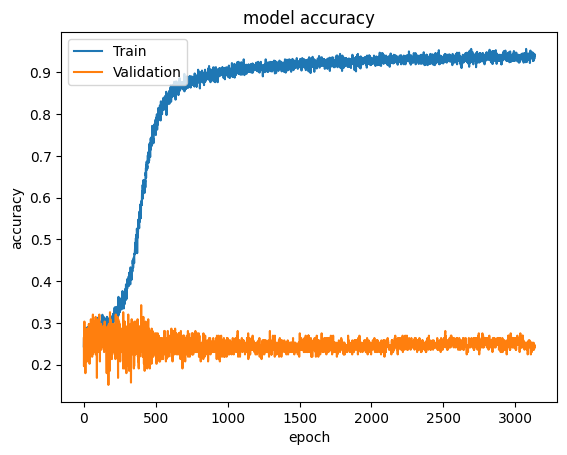

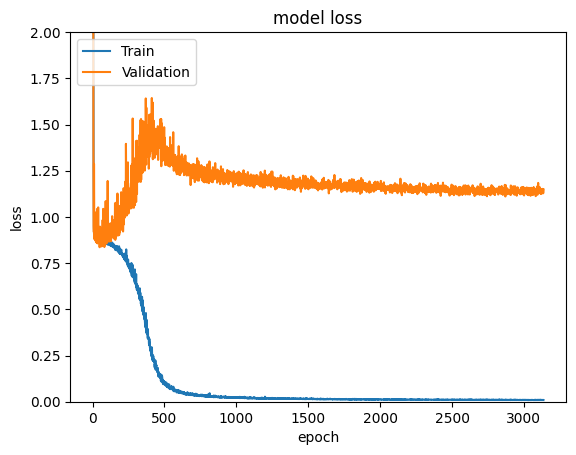

<Figure size 640x480 with 0 Axes>

In [87]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_accuracy_2010_to_present.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,2)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_loss_2010_to_present.png')

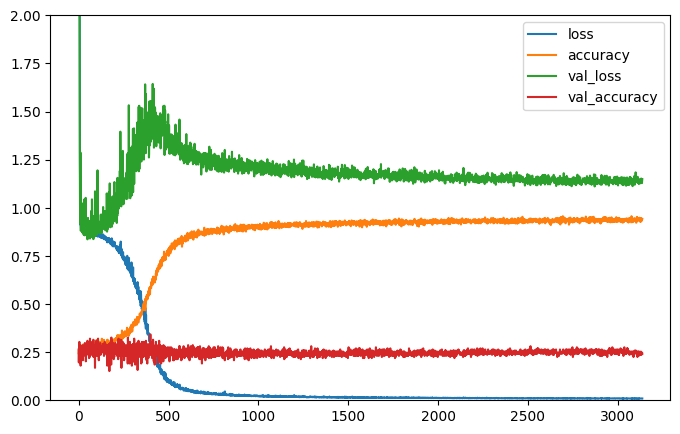

<Figure size 640x480 with 0 Axes>

In [88]:
pd.DataFrame(history.history).plot(figsize=(8,5))

plt.ylim(0,2)
plt.show()
#plt.savefig('model_hist_2010_to_present.png')

In [89]:
#model.save("model_2010_to_present.tf", overwrite=True, save_format="tf")

In [90]:
#pd.DataFrame.from_dict(history.history).to_csv('history_2010_to_present.csv',index=False)

Lastly, let's see if we can improve the validation accuracy again. Let's get more data. This time the data was scraped from the New York goverment website. The cleaing process can be found at clean_2002_mega_millions_data.ipynb.

In [159]:
df = pd.read_csv("data//mega_millions_2002_to_present.csv")

In [160]:
df1 = df.copy()
df.drop(['date'], axis=1, inplace=True)

number_of_features = df.shape[1]

In [161]:
df1.head()

,date,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,08/29/2023,9.0,39.0,52.0,61.0,63.0,25.0,3.0
1,08/25/2023,12.0,23.0,26.0,31.0,38.0,2.0,2.0
2,08/22/2023,1.0,12.0,26.0,36.0,50.0,7.0,2.0
3,08/18/2023,10.0,20.0,29.0,44.0,66.0,11.0,3.0
4,08/15/2023,18.0,39.0,42.0,57.0,63.0,7.0,3.0


In [162]:
df.head()

,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,9.0,39.0,52.0,61.0,63.0,25.0,3.0
1,12.0,23.0,26.0,31.0,38.0,2.0,2.0
2,1.0,12.0,26.0,36.0,50.0,7.0,2.0
3,10.0,20.0,29.0,44.0,66.0,11.0,3.0
4,18.0,39.0,42.0,57.0,63.0,7.0,3.0


In [163]:
train = df.copy()
train.head((window_length+1))

,ball_1,ball_2,ball_3,ball_4,ball_5,mega_ball,mega_plier
0,9.0,39.0,52.0,61.0,63.0,25.0,3.0
1,12.0,23.0,26.0,31.0,38.0,2.0,2.0
2,1.0,12.0,26.0,36.0,50.0,7.0,2.0
3,10.0,20.0,29.0,44.0,66.0,11.0,3.0
4,18.0,39.0,42.0,57.0,63.0,7.0,3.0
5,8.0,9.0,18.0,35.0,41.0,18.0,3.0
6,13.0,19.0,20.0,32.0,33.0,14.0,2.0
7,11.0,30.0,45.0,52.0,56.0,20.0,2.0


In [164]:
# Define the number of rows in the data set
train_rows = train.values.shape[0]

# Initialize the training sample and label arrays
train_samples = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
train_labels = np.empty([ train_rows - window_length, number_of_features], dtype=float)

This time, the training set has 2212 samples while the previous has 1321. 

In [165]:
print(train_rows)
print(train_samples.shape)
print(train_labels.shape)

2219
(2212, 7, 7)
(2212, 7)


In [97]:
for i in range(0, train_rows-window_length):
    train_samples[i] = train.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    train_labels[i] = train.iloc[i : i+1, 0 : number_of_features]

In [98]:
scaler = StandardScaler()
transformed_dataset = scaler.fit_transform(train.values)
scaled_train_samples = pd.DataFrame(data=transformed_dataset, index=train.index)

In [99]:
x_train = np.empty([ train_rows - window_length, window_length, number_of_features], dtype=float)
y_train = np.empty([ train_rows - window_length, number_of_features], dtype=float)

for i in range(0, train_rows-window_length):
    x_train[i] = scaled_train_samples.iloc[i+1 : i+window_length+1, 0 : number_of_features]
    y_train[i] = scaled_train_samples.iloc[i : i+1, 0 : number_of_features]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [101]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [102]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [103]:
#model for 2010 to 2022

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=1200
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/2000
08:25:11 PM
17/17 - 18s - loss: 0.8434 - accuracy: 0.3318 - val_loss: 0.8252 - val_accuracy: 0.3913 - 18s/epoch - 1s/step
Epoch 2/2000
08:25:11 PM
17/17 - 0s - loss: 0.7964 - accuracy: 0.3666 - val_loss: 0.8413 - val_accuracy: 0.4147 - 366ms/epoch - 22ms/step
Epoch 3/2000
08:25:11 PM
17/17 - 0s - loss: 0.7652 - accuracy: 0.3749 - val_loss: 0.8362 - val_accuracy: 0.4114 - 273ms/epoch - 16ms/step
Epoch 4/2000
08:25:12 PM
17/17 - 0s - loss: 0.7700 - accuracy: 0.3714 - val_loss: 0.8220 - val_accuracy: 0.4080 - 287ms/epoch - 17ms/step
Epoch 5/2000
08:25:12 PM
17/17 - 0s - loss: 0.7759 - accuracy: 0.3785 - val_loss: 0.8119 - val_accuracy: 0.4214 - 273ms/epoch - 16ms/step
Epoch 6/2000
08:25:12 PM
17/17 - 0s - loss: 0.7562 - accuracy: 0.3714 - val_loss: 0.8405 - val_accuracy: 0.3278 - 268ms/epoch - 16ms/step
Epoch 7/2000
08:25:13 PM
17/17 - 0s - loss: 0.7691 - accuracy: 0.3797 - val_loss: 0.8110 - val_accuracy: 0.4114 - 373ms/epoch - 22ms/step
Epoch 8/2000
08:25:13 PM
17/17 - 0s -

In [104]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 97%.
The validation accuracy is 31%.
The test accuracy is 30%.


In [105]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 7.205 minutes.


In [109]:
# Initialising the RNN
model = Sequential()
# Adding the input layer and the LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a first Dropout layer
model.add(Dropout(0.2))
# Adding a second LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a second Dropout layer
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = True)))
# Adding a fourth LSTM layer
model.add(Bidirectional(LSTM(240,
                        input_shape = (window_length, number_of_features), recurrent_regularizer=l2(0.05),
                        return_sequences = False)))
# Adding a third Dropout layer
model.add(Dropout(0.2))
# Adding the first output layer
model.add(Dense(70))
# Adding the last output layer
model.add(Dense(number_of_features))

In [110]:
model.compile(optimizer="rmsprop", loss ='mse', metrics=['accuracy'])

In [111]:
#model for 2002 to present

time_callback = TimeHistory()
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-4 more"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 50 epochs"
        patience=100,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=2750
    ), time_callback
]
history=model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3400,
    batch_size=100,
    callbacks=callbacks,
    verbose=2
)

Streaming output truncated to the last 5000 lines.
Epoch 1242/3400
08:39:46 PM
17/17 - 0s - loss: 0.0132 - accuracy: 0.9267 - val_loss: 1.0584 - val_accuracy: 0.3278 - 302ms/epoch - 18ms/step
Epoch 1243/3400
08:39:47 PM
17/17 - 0s - loss: 0.0131 - accuracy: 0.9196 - val_loss: 1.0720 - val_accuracy: 0.3110 - 280ms/epoch - 16ms/step
Epoch 1244/3400
08:39:47 PM
17/17 - 0s - loss: 0.0129 - accuracy: 0.9273 - val_loss: 1.0713 - val_accuracy: 0.3244 - 346ms/epoch - 20ms/step
Epoch 1245/3400
08:39:47 PM
17/17 - 0s - loss: 0.0131 - accuracy: 0.9261 - val_loss: 1.0622 - val_accuracy: 0.3110 - 467ms/epoch - 27ms/step
Epoch 1246/3400
08:39:48 PM
17/17 - 0s - loss: 0.0134 - accuracy: 0.9225 - val_loss: 1.0743 - val_accuracy: 0.3144 - 423ms/epoch - 25ms/step
Epoch 1247/3400
08:39:48 PM
17/17 - 0s - loss: 0.0134 - accuracy: 0.9279 - val_loss: 1.0667 - val_accuracy: 0.3144 - 485ms/epoch - 29ms/step
Epoch 1248/3400
08:39:49 PM
17/17 - 0s - loss: 0.0133 - accuracy: 0.9143 - val_loss: 1.0846 - val_accur

In [112]:
acc_train = model.evaluate(X_train, y_train, batch_size = 100, verbose=0, callbacks=callbacks)
print("The train accuracy is "+str(int(acc_train[1]*100))+"%.")
acc_test = model.evaluate(X_val, y_val, batch_size = 100, verbose=0, callbacks=callbacks)
print("The validation accuracy is "+str(int(acc_test[1]*100))+"%.")
acc_test = model.evaluate(X_test, y_test, batch_size = 100, verbose=0, callbacks=callbacks)
print("The test accuracy is "+str(int(acc_test[1]*100))+"%.")

The train accuracy is 97%.
The validation accuracy is 34%.
The test accuracy is 38%.


In [113]:
print("The total calculation time was "+str(round(sum(time_callback.times)/60,3))+" minutes.")

The total calculation time was 15.29 minutes.


We can see the validation and training accuracy are pretty high. Much higher than the odds of winning the lottery without machine learning!

In [114]:
print('-' * 40)
print('Prediction vs. GoundTruth without rounding up or down')

n = randint(0,1000)
seed(n)
for i in range(0,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0])
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth without rounding up or down
1/1 [==============================] - 3s 3s/step
Drawing  Date 12/19/2014
Prediction:	 [14 17 58 58 67  3  3]
GoundTruth:	 [14 18 58 59 68  4  3]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 03/18/2016
Prediction:	 [ 5  8 58 60 73 12  4]
GoundTruth:	 [ 5  8 57 59 73 13  5]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 09/15/2006
Prediction:	 [ 5 20 31 35 50 36  0]
GoundTruth:	 [ 6 26 33 39 55  1  0]
----------------------------------------
1/1 [==============================] - 0s 27ms/step
Drawing  Date 02/04/2014
Prediction:	 [25 43 48 59 72  8  3]
GoundTruth:	 [25 44 49 60 73  9  3]
----------------------------------------
1/1 [==============================] - 0s 25ms/step
Drawing  Date 11/02/2007
Prediction:	 [ 0  2 34 49 52 19  0]
GoundTruth:	 [ 1  3 34 49 52 19  0

In [115]:
print('-' * 40)
print('Prediction vs. GoundTruth with rounding up')

seed(n)
for i in range(1,10):
    k = randint(0, df1.shape[0]-10-window_length)
    test = df1.copy()
    test = test.head((window_length+10-k))
    test = test.tail((window_length+1))
    test_Date = df1.iloc[ (test.head().index[0]) ]['date']
    test1 = test.tail((window_length))
    test1 = test1.drop(['date'], errors='ignore', axis=1)
    test1 = np.array(test1)
    x_test = scaler.transform(test1)
    y_test_pred = model.predict(np.array([x_test]))
    y_test_true = test.drop(['date'], errors='ignore', axis=1)
    y_test_true = y_test_true.head(1)
    print('Drawing  Date', test_Date)
    print('Prediction:\t', scaler.inverse_transform(y_test_pred).astype(int)[0]+1)
    print('GoundTruth:\t', np.array(y_test_true.astype(int))[0])
    print('-' * 40)

----------------------------------------
Prediction vs. GoundTruth with rounding up
1/1 [==============================] - 0s 23ms/step
Drawing  Date 12/19/2014
Prediction:	 [15 18 59 59 68  4  4]
GoundTruth:	 [14 18 58 59 68  4  3]
----------------------------------------
1/1 [==============================] - 0s 34ms/step
Drawing  Date 03/18/2016
Prediction:	 [ 6  9 59 61 74 13  5]
GoundTruth:	 [ 5  8 57 59 73 13  5]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 09/15/2006
Prediction:	 [ 6 21 32 36 51 37  1]
GoundTruth:	 [ 6 26 33 39 55  1  0]
----------------------------------------
1/1 [==============================] - 0s 26ms/step
Drawing  Date 02/04/2014
Prediction:	 [26 44 49 60 73  9  4]
GoundTruth:	 [25 44 49 60 73  9  3]
----------------------------------------
1/1 [==============================] - 0s 23ms/step
Drawing  Date 11/02/2007
Prediction:	 [ 1  3 35 50 53 20  1]
GoundTruth:	 [ 1  3 34 49 52 19  0]
-------

In [116]:
last_Date = df1.iloc[0]['date']
print('-' * 40)
print('Predict the Drawing on '+datetime.strptime(str(last_Date),'%m/%d/%Y').strftime("%b %d %Y")+ ' vs. True Drawing')
next_draw = df.copy()
next_draw = next_draw.head((window_length+1))
next_draw1 = next_draw.tail((window_length))
next_draw1 = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw1 = np.array(next_draw1)
x_next = scaler.transform(next_draw1)
y_next_pred = model.predict(np.array([x_next]))
y_test_true = next_draw.drop(['date'], errors='ignore', axis=1)
y_test_true = y_test_true.head(1)
print('Drawing  Date', last_Date)
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('Truth                                 :\t', np.array(y_test_true.astype(int))[0])
print('-' * 40)

----------------------------------------
Predict the Drawing on Aug 29 2023 vs. True Drawing
1/1 [==============================] - 4s 4s/step
Drawing  Date 08/29/2023
Prediction without rounding up or down:	 [ 7 13 22 41 48 10  3]
Prediction with rounding up           :	 [ 8 14 23 42 49 11  4]
Prediction with rounding down         :	 [ 6 12 21 40 47  9  2]
Truth                                 :	 [ 9 39 52 61 63 25  3]
----------------------------------------


In [117]:
print('-' * 40)
print('Predict the Next Drawing')
next_draw = df.copy()
next_draw = next_draw.head((window_length))
next_draw = next_draw.drop(['date'], errors='ignore', axis=1)
next_draw = np.array(next_draw)
x_next = scaler.transform(next_draw)
y_next_pred = model.predict(np.array([x_next]))
print('Next Drawing')
print('Prediction without rounding up or down:\t', scaler.inverse_transform(y_next_pred).astype(int)[0])
print('Prediction with rounding up           :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]+1)
print('Prediction with rounding down         :\t', scaler.inverse_transform(y_next_pred).astype(int)[0]-1)
print('-' * 40)

----------------------------------------
Predict the Next Drawing
1/1 [==============================] - 0s 23ms/step
Next Drawing
Prediction without rounding up or down:	 [ 9 11 25 50 60  8  2]
Prediction with rounding up           :	 [10 12 26 51 61  9  3]
Prediction with rounding down         :	 [ 8 10 24 49 59  7  1]
----------------------------------------


At the time of finishing this project, I realized that a Mega Millions lottery had been drawn a couple nights before. The drawing was for September 1st, 2023. I decided to see how my results matched up. The results of correct balls were: a ball, a mega millions, and the multiplier. While I am still unsure if a machine can learn the lotto, this certainly was a fun exercise.

In [2]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="sept_1_drawing.png", width=700, height=700)

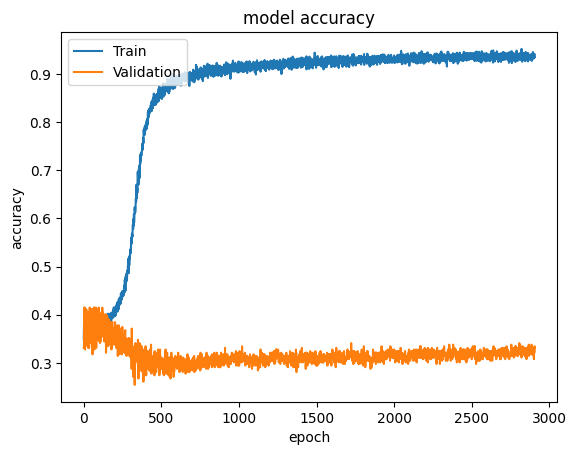

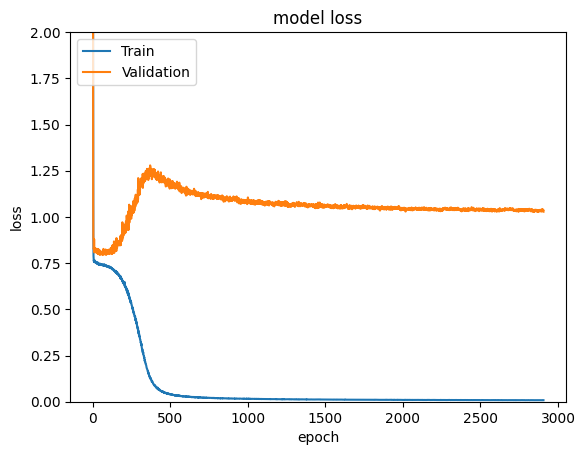

<Figure size 640x480 with 0 Axes>

In [118]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_accuracy_2002_to_present.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,2)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('model_loss_2002_to_present.png')

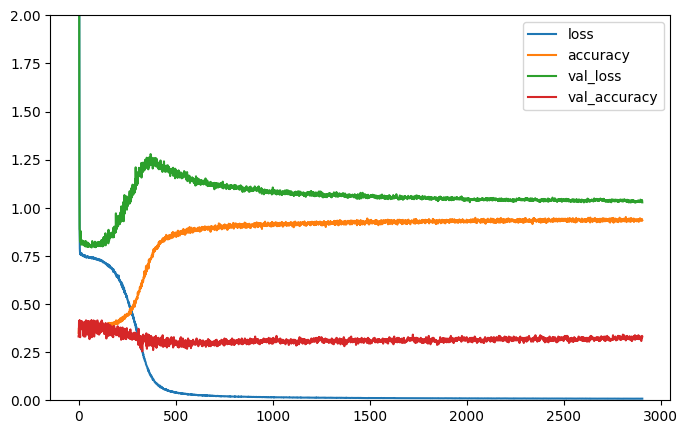

<Figure size 640x480 with 0 Axes>

In [119]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylim(0,2)
plt.show()
#plt.savefig('model_hist_2002_to_present.png')

In [120]:
#model.save("model_2002_to_present.tf", overwrite=True, save_format="tf")

In [121]:
#pd.DataFrame.from_dict(history.history).to_csv('history_2002_to_present.csv',index=False)

In [122]:
#!zip -r model_2010_to_2022.zip model_2010_to_2022.tf/

  adding: model_2010_to_2022.tf/ (stored 0%)
  adding: model_2010_to_2022.tf/saved_model.pb (deflated 91%)
  adding: model_2010_to_2022.tf/keras_metadata.pb (deflated 94%)
  adding: model_2010_to_2022.tf/variables/ (stored 0%)
  adding: model_2010_to_2022.tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_2010_to_2022.tf/variables/variables.index (deflated 66%)
  adding: model_2010_to_2022.tf/fingerprint.pb (stored 0%)
  adding: model_2010_to_2022.tf/assets/ (stored 0%)


In [123]:
#!zip -r model_2010_to_present.zip model_2010_to_present.tf/

  adding: model_2010_to_present.tf/ (stored 0%)
  adding: model_2010_to_present.tf/saved_model.pb (deflated 91%)
  adding: model_2010_to_present.tf/keras_metadata.pb (deflated 94%)
  adding: model_2010_to_present.tf/variables/ (stored 0%)
  adding: model_2010_to_present.tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_2010_to_present.tf/variables/variables.index (deflated 66%)
  adding: model_2010_to_present.tf/fingerprint.pb (stored 0%)
  adding: model_2010_to_present.tf/assets/ (stored 0%)


In [124]:
#!zip -r model_2002_to_present.zip model_2002_to_present.tf/

  adding: model_2002_to_present.tf/ (stored 0%)
  adding: model_2002_to_present.tf/saved_model.pb (deflated 91%)
  adding: model_2002_to_present.tf/keras_metadata.pb (deflated 94%)
  adding: model_2002_to_present.tf/variables/ (stored 0%)
  adding: model_2002_to_present.tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_2002_to_present.tf/variables/variables.index (deflated 66%)
  adding: model_2002_to_present.tf/fingerprint.pb (stored 0%)
  adding: model_2002_to_present.tf/assets/ (stored 0%)
